In [136]:
# %%
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt

plt.style.use("custom_standard")
plt.style.use("custom_small")
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools
import copy
from pathlib import Path
import re
import umap
from sklearn.preprocessing import OneHotEncoder
import lir_proteome_screen_pssm.data_loaders as dl
import lir_proteome_screen_pssm.stats as stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# scoring ilir and screening PSSMs

Test sets: 7mers
- screening - [FWY]xx[LVI]
- screening - [FWY]xx[FWY]
- lir central - (not the augmented set)


PSSM foregrounds:
- ilir
- screening data:
    - different z-score ranges

PSSM background:
- proteome

psuedocounts:
- 1.0

In [127]:
screening_split = dl.ScreeningTrainTestSplit()
screening_split

ScreeningTrainTestSplit(screening_v1)
created_at - 2025-06-01T17:47:22.206106
train_size - 208
xxx[FWY]xx[LVI]_screen_test_size-binders - 40
xxx[FWY]xx[LVI]_screen_test_size-nonbinders - 40
xxx[FWY]xx[WFY]_screen_test_size-binders - 30
xxx[FWY]xx[WFY]_screen_test_size-nonbinders - 30
random_seed - 73
source_data - ['/Users/jackson/MIT Dropbox/Jackson Halpin/work/11-lir_pssm_scoring/pssm_lc3b_lir-adjacent/data/processed/ilir_binders.csv', '/Users/jackson/MIT Dropbox/Jackson Halpin/work/11-lir_pssm_scoring/pssm_lc3b_lir-adjacent/data/processed/screen-binders.csv', '/Users/jackson/MIT Dropbox/Jackson Halpin/work/11-lir_pssm_scoring/pssm_lc3b_lir-adjacent/data/processed/screen-nonbinders.csv']
version - v1
lir_types - {'...[FWY]..[LVI]': {'test_size': 80, 'test_binders': 40, 'test_nonbinders': 40}, '...[FWY]..[WFY]': {'test_size': 60, 'test_binders': 30, 'test_nonbinders': 30}}

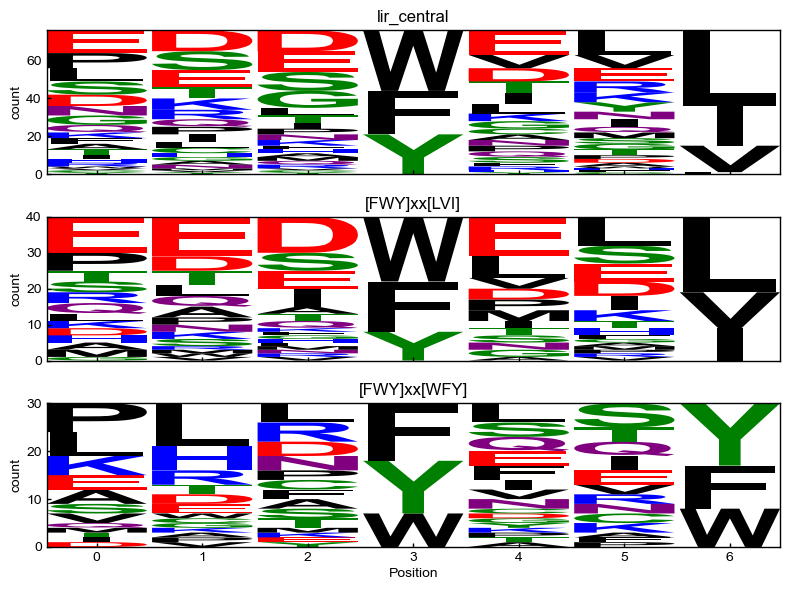

In [137]:
test_sets = {
    "lir_central":dl.TEST_SETS.lir_central.copy(),
    "[FWY]xx[LVI]":screening_split.test_LVI.copy(),
    "[FWY]xx[WFY]":screening_split.test_WFY.copy()
}
for k, v in test_sets.items():
    test_sets[k] = v.rename(columns={'binding_label': 'true label'})

n_plots = len(test_sets)
fig, axes = plt.subplots(
    nrows=n_plots,
    ncols=1,
    figsize=(8, 2 * n_plots),
    sharex=True,
)
for ax, (name, testset) in zip(axes, test_sets.items()):
    ax.set_title(name)
    pssms.plot_logo(
        pssms.seqlist_2_counts_matrix(testset[testset['true label']==1]["7mer"].to_list()),
        ax=ax,
    )
    ax.set_ylabel("count")
axes[-1].set_xlabel("Position")
plt.tight_layout()

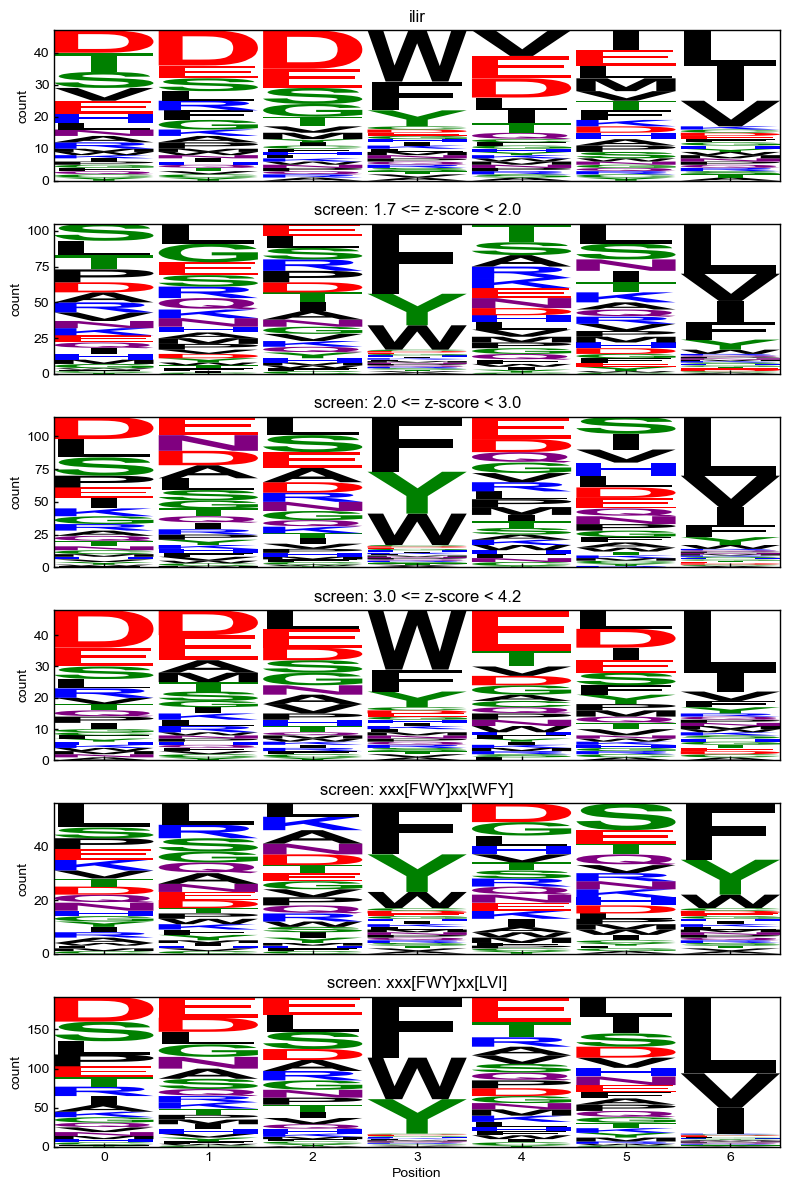

In [138]:
pseudo_count = 1
z_score_ranges = [
    [1.7, 2.0],
    [2.0, 3.0],
    [3.0, 4.2],
]
screening_train = screening_split.train.copy()
foregrounds = {
    "ilir": dl.PROCESSED_SEQUENCE_TABLES.ilir_binders["7mer"].to_list(),
}
for z_score_range in z_score_ranges:
    temp = screening_train[
        (screening_train["avg_z_score"] >= z_score_range[0])
        & (screening_train["avg_z_score"] < z_score_range[1])
    ].copy()
    foregrounds[f"screen: {z_score_range[0]} <= z-score < {z_score_range[1]}"] = temp["7mer"].to_list()
foregrounds["screen: xxx[FWY]xx[WFY]"] = screening_train[screening_train["lir_type"]=="...[FWY]..[WFY]"]["7mer"].to_list()
foregrounds["screen: xxx[FWY]xx[LVI]"] = screening_train[screening_train["lir_type"]=="...[FWY]..[LVI]"]["7mer"].to_list()


for k, v in foregrounds.items():
    foregrounds[k] = pssms.seqlist_2_counts_matrix(v, pseudocount=pseudo_count)
foregrounds.keys()
n_plots = len(foregrounds)
fig, axes = plt.subplots(
    nrows=n_plots,
    ncols=1,
    figsize=(8, 2 * n_plots),
    sharex=True,
)
for ax, (name, foreground) in zip(axes, foregrounds.items()):
    ax.set_title(name)
    pssms.plot_logo(
        foreground,
        ax=ax,
    )
    ax.set_ylabel("count")
axes[-1].set_xlabel("Position")
plt.tight_layout()

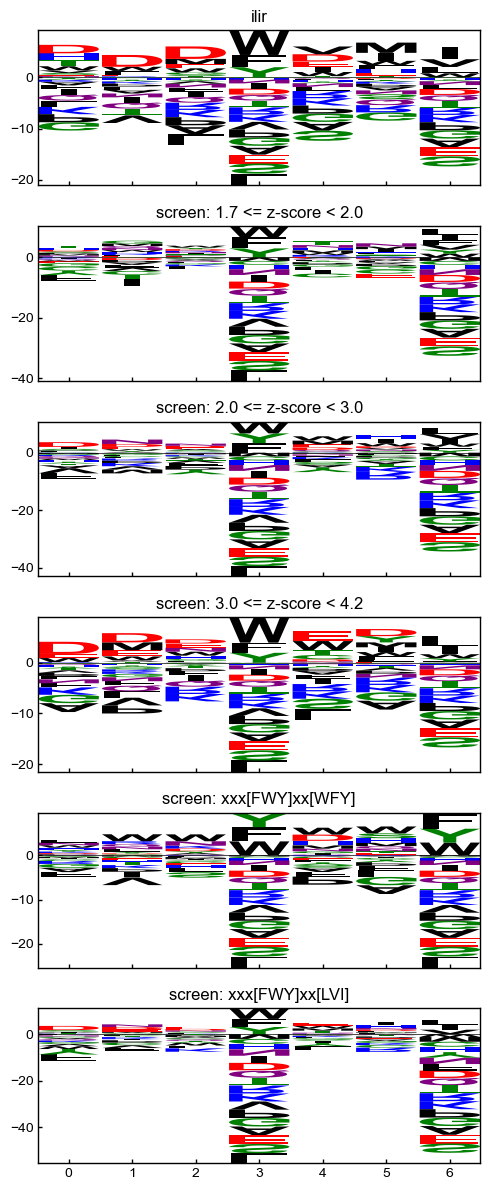

In [139]:
BG = dl.BGFREQS.proteome
pssm_dict = {}
for name, foreground in foregrounds.items():
    pssm = pssms.make_pssm(
        df_counts=foreground,
        bg=BG,
    )
    pssm_dict[name] = pssm

fig, axes = plt.subplots(
    nrows=len(pssm_dict),
    ncols=1,
    figsize=(5, 2 * len(pssm_dict)),
    sharex=True,
)
for ax, (name, pssm) in zip(axes, pssm_dict.items()):
    pssms.plot_logo(pssm, title=name, ax=ax)
    ax.set_title(name)
plt.tight_layout()

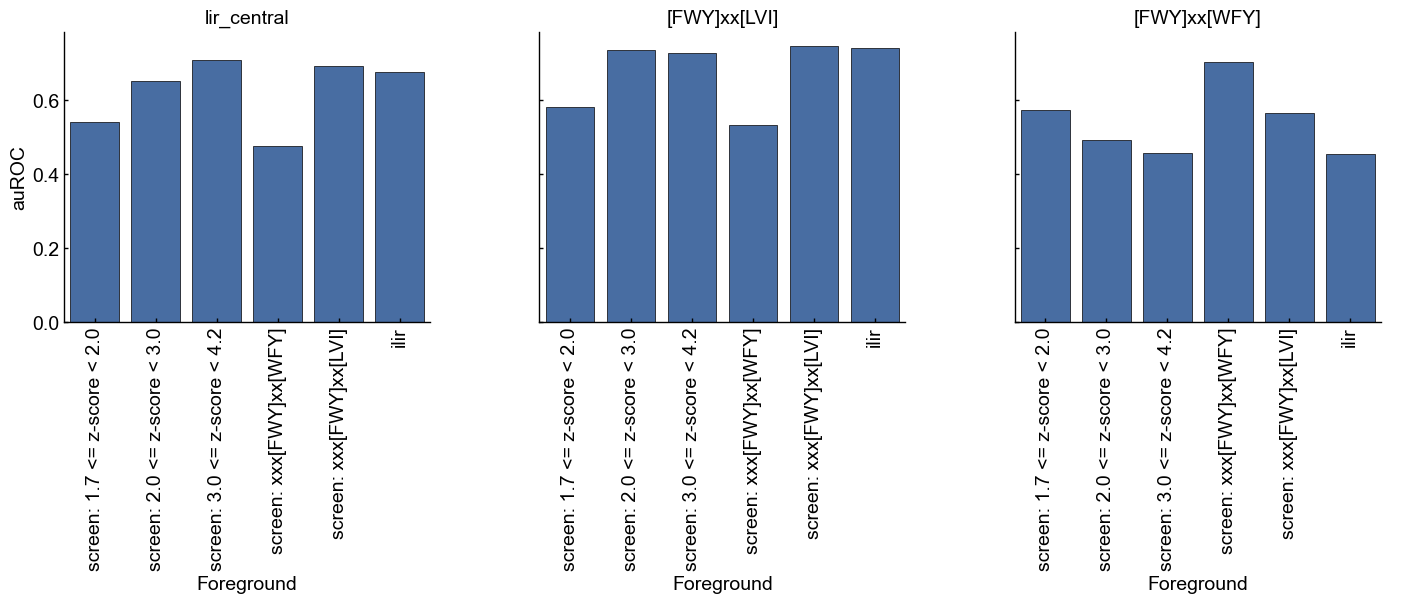

In [140]:
auc_results = []
scores = []
pssms_dict = {}

for foreground, pssm in pssm_dict.items():
    for test_set_name, test_set in test_sets.items():
        temp_df = test_set.copy()
        temp_df["pssm_score"] = temp_df["7mer"].apply(
            pssms.PSSM_score_sequence, PSSM=pssm
        )
        auroc = stats.df_2_roc_auc(temp_df, "true label", "pssm_score")
        auc_results.append(
            {
                "foreground": foreground,
                "test set": test_set_name,
                "auROC": auroc,
            }
        )
auc_results_df = pd.DataFrame(auc_results)



#increase font size
plt.rcParams.update({"font.size": 14})
order = [
    "screen: 1.7 <= z-score < 2.0",
    "screen: 2.0 <= z-score < 3.0",
    "screen: 3.0 <= z-score < 4.2",
    "screen: xxx[FWY]xx[WFY]",
    "screen: xxx[FWY]xx[LVI]",
    "ilir",
]
g = sns.catplot(
    data=auc_results_df,
    x="foreground",
    y="auROC",
    col="test set",
    kind="bar",
    sharey=True,
    height=4,
    aspect=1.2,
    order=order
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Foreground", "auROC")
# g.despine(left=True)

In [132]:
screen_binders = dl.PROCESSED_SEQUENCE_TABLES.screen_binders.copy()

In [133]:
def match_regex(seq, re_pattern1, re_pattern2):
    if re.fullmatch(re_pattern1, seq):
        return re_pattern1
    elif re.fullmatch(re_pattern2, seq):
        return re_pattern2
    else:
        return np.nan

old_regex = "...[FWY]..[LVI]"
new_regex = "...[FWY]..[WFY]"
screen_binders["lir_type"] = screen_binders["7mer"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)

<Axes: xlabel='lir_type', ylabel='avg_z_score'>

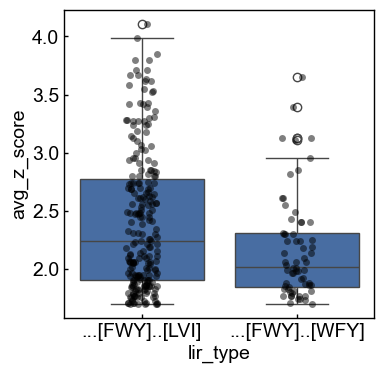

In [134]:
fig, ax = plt.subplots()
sns.stripplot(
    data=screen_binders,
    x="lir_type",
    y="avg_z_score",
    ax=ax,
    jitter=True,
    alpha=0.5,
    color="black",
)
sns.boxplot(
    data=screen_binders,
    x="lir_type",
    y="avg_z_score",
    ax=ax,
)

<Axes: >

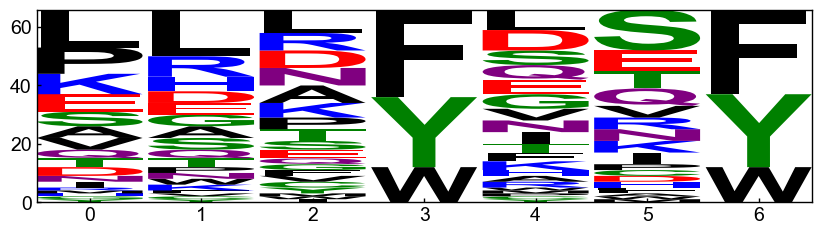

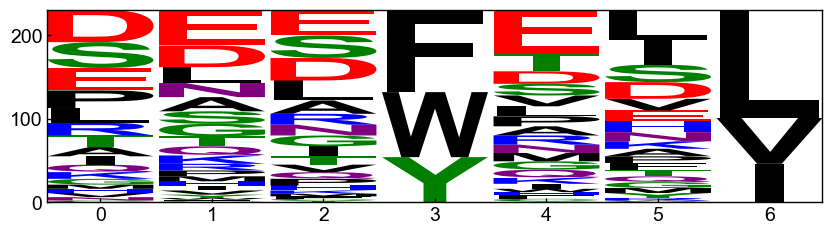

In [135]:
pssms.plot_logo(pssms.seqlist_2_counts_matrix(screen_binders[screen_binders["lir_type"]=="...[FWY]..[WFY]"]["7mer"].to_list()))
pssms.plot_logo(pssms.seqlist_2_counts_matrix(screen_binders[screen_binders["lir_type"]=="...[FWY]..[LVI]"]["7mer"].to_list()))